# Deep Learning
## Assignment-10
### Poojitha Venkatram

GitHub Link- https://github.com/poojithavenkatram/Deep-Learning

In [ ]:
!pip install transformers

In [ ]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering
import time

In [ ]:
# !mkdir squad
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

--2024-04-23 06:02:04--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

squad/train-v2.0.js 100%[===================>]  40.17M  --.-KB/s    in 0.1s    

2024-04-23 06:02:07 (290 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2024-04-23 06:02:07--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad/dev-v2.0.json’

squ

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchtext.datasets import SQuAD2

# Load the dataset
train_iter, dev_iter = SQuAD2(root='.data', split=('train', 'dev'))

# Create a DataLoader for handling the DataPipe
train_dataloader = DataLoader(train_iter, batch_size=1)

# Fetch the first 20 question-answer pairs from the training set
qa_pairs = []
try:
    for i, batch in enumerate(train_dataloader):
        # Unpack each element from the batch
        context_tuple, question_tuple, answers_list, answer_positions_list = batch

        # Extract single elements from tuples and lists
        context = context_tuple[0]  # First element of the first tuple
        question = question_tuple[0]  # First element of the second tuple
        answers = [ans for ans in answers_list]  # List comprehension to create a flat list of answers

        # Store each Q&A pair
        qa_pairs.append({'context': context, 'question': question, 'answers': answers})

        # Stop after collecting 20 pairs
        if i >= 19:
            break

except Exception as e:
    print(f"An error occurred: {str(e)}")

In [ ]:
import json

# Define the path to the SQuAD 2.0 training data
path = "squad/train-v2.0.json"

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    # Loop through each group and paragraph to extract text, question, and answer details
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    # Store the text, question, and both text and start index of the answer
                    texts.append(context)
                    questions.append(question)
                    answers.append({'text': answer['text'], 'start': answer['answer_start']})

                # Break out of loops after collecting 30 data points
                if len(questions) >= 30:
                    break
            if len(questions) >= 30:
                break
        if len(questions) >= 30:
            break

    return texts[:30], questions[:30], answers[:30]

# Load data
train_texts, train_queries, train_answers = load_squad_data(path)

In [ ]:
# Display the first 5 records from each list
for i in range(5):
    answer = train_answers[i]
    text = train_texts[i]
    question = train_queries[i]

    # Extract the answer specifics
    answer_text = answer['text']
    start_idx = answer['start']
    end_idx = start_idx + len(answer_text)
    context_extract = text[start_idx:end_idx]  # Extract the exact answer from the context

    print(f"Text {i+1}: {text}")
    print(f"Question {i+1}: {question}")
    print(f"Answer {i+1}: {answer_text}")

Text 1: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Question 1: When did Beyonce start becoming popular?
Answer 1: in the late 1990s
Text 2: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various s

In [ ]:
# Calculate and display start and end positions for the first 5 records
for i in range(5):
    answer = train_answers[i]
    text = train_texts[i]
    question = train_queries[i]

    answer_text = answer['text']
    start_idx = answer['start']
    end_idx = start_idx + len(answer_text)

    print(f"Record {i+1}:")
    print(f"Question: {question}")
    print(f"Answer: {answer_text}")
    print(f"Text Context Extract: {text[start_idx:end_idx]}")
    print(f"Start Position: {start_idx}, End Position: {end_idx}\n")

Record 1:
Question: When did Beyonce start becoming popular?
Answer: in the late 1990s
Text Context Extract: in the late 1990s
Start Position: 269, End Position: 286

Record 2:
Question: What areas did Beyonce compete in when she was growing up?
Answer: singing and dancing
Text Context Extract: singing and dancing
Start Position: 207, End Position: 226

Record 3:
Question: When did Beyonce leave Destiny's Child and become a solo singer?
Answer: 2003
Text Context Extract: 2003
Start Position: 526, End Position: 530

Record 4:
Question: In what city and state did Beyonce  grow up? 
Answer: Houston, Texas
Text Context Extract: Houston, Texas
Start Position: 166, End Position: 180

Record 5:
Question: In which decade did Beyonce become famous?
Answer: late 1990s
Text Context Extract: late 1990s
Start Position: 276, End Position: 286



In [ ]:
from pathlib import Path
import json

# Give the path for SQuAD 2.0 validation data
path = Path('squad/dev-v2.0.json')

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    # Store both the text and the start index of the answer
                    answers.append({'text': answer['text'], 'start': answer['answer_start']})
                    questions.append(question)
                    texts.append(context)

                # Break the inner loops if we've collected enough data
                if len(questions) >= 30:
                    break
            if len(questions) >= 30:
                break
        if len(questions) >= 30:
            break

    # Return only the first 30 items from each list
    return texts[:30], questions[:30], answers[:30]

val_texts, val_queries, val_answers = load_squad_data(path)

In [ ]:
# Display the first 5 records from each list
for i in range(5):
    print(f"Text {i+1}: {val_texts[i]}")
    print(f"Question {i+1}: {val_queries[i]}")
    print(f"Answer {i+1}: {val_answers[i]}")
    print("\n")

Text 1: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question 1: In what country is Normandy located?
Answer 1: France


Text 2: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They w

In [ ]:
# Calculate and display start and end positions for the first 5 records
for i in range(5):
    answer = val_answers[i]
    text = val_texts[i]
    question = val_queries[i]

    answer_text = answer['text']
    start_idx = answer['start']
    end_idx = start_idx + len(answer_text)

    print(f"Record {i+1}:")
    print(f"Question: {question}")
    print(f"Answer: {answer_text}")
    print(f"Text Context Extract: {text[start_idx:end_idx]}")
    print(f"Start Position: {start_idx}, End Position: {end_idx}\n")

Record 1:
Question: In what country is Normandy located?
Answer: France
Text Context Extract: France
Start Position: 159, End Position: 165

Record 2:
Question: In what country is Normandy located?
Answer: France
Text Context Extract: France
Start Position: 159, End Position: 165

Record 3:
Question: In what country is Normandy located?
Answer: France
Text Context Extract: France
Start Position: 159, End Position: 165

Record 4:
Question: In what country is Normandy located?
Answer: France
Text Context Extract: France
Start Position: 159, End Position: 165

Record 5:
Question: When were the Normans in Normandy?
Answer: 10th and 11th centuries
Text Context Extract: 10th and 11th centuries
Start Position: 94, End Position: 117



In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

30
30
30


In [ ]:
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'start': 269}


In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

30
30
30


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

#### Preprocess the Data

##### Find the start and end position character

In [ ]:
for i in range(len(train_answers)):
    answer = train_answers[i]
    text = train_texts[i]

    real_answer = answer['text']
    start_idx = answer['start']  # Updated to use the correct key based on previous loading code
    end_idx = start_idx + len(real_answer)

    # Check if the sliced text matches the real answer exactly
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is off by one character
    elif start_idx > 0 and text[start_idx-1:end_idx-1] == real_answer:
        answer['start'] = start_idx - 1  # Update 'start' to reflect the new start index
        answer['answer_end'] = end_idx - 1
    # When the real answer is off by two characters
    elif start_idx > 1 and text[start_idx-2:end_idx-2] == real_answer:
        answer['start'] = start_idx - 2  # Update 'start' to reflect the new start index
        answer['answer_end'] = end_idx - 2

    # Update the answer in the list with modified indices
    train_answers[i] = answer

In [ ]:
for i in range(len(val_answers)):
    answer = val_answers[i]
    text = val_texts[i]

    real_answer = answer['text']
    start_idx = answer['start']  # Ensure this key is consistent with how data is loaded
    end_idx = start_idx + len(real_answer)

    # Check if the sliced text matches the real answer exactly
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is off by one character
    elif start_idx > 0 and text[start_idx-1:end_idx-1] == real_answer:
        answer['start'] = start_idx - 1  # Adjust 'start' to reflect the new start index
        answer['answer_end'] = end_idx - 1
    # When the real answer is off by two characters
    elif start_idx > 1 and text[start_idx-2:end_idx-2] == real_answer:
        answer['start'] = start_idx - 2  # Adjust 'start' to reflect the new start index
        answer['answer_end'] = end_idx - 2

    # Update the answer in the list with modified indices
    val_answers[i] = answer

##### Tokenize passages and queries

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

##### Convert the start-end positions to tokens start-end positions

In [ ]:
def add_token_positions(encodings, answers, tokenizer):
    start_positions = []
    end_positions = []

    count = 0  # To count truncation occurrences

    for i in range(len(answers)):
        # Convert character start positions to token start positions
        start_pos = answers[i]['start']
        end_pos = answers[i]['answer_end']

        start_token = encodings.char_to_token(i, start_pos)
        end_token = encodings.char_to_token(i, end_pos)

        # Handle None for start position (answer might be truncated)
        if start_token is None:
            start_positions.append(tokenizer.model_max_length)
        else:
            start_positions.append(start_token)

        # Handle None for end position similarly
        if end_token is None:
            end_token = encodings.char_to_token(i, end_pos - 1)
            if end_token is None:
                count += 1  # Increment truncation count
                end_positions.append(tokenizer.model_max_length)
            else:
                end_positions.append(end_token)
        else:
            end_positions.append(end_token)

    # Update the encoding dictionary to include start and end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

    # Print the count of truncated answers
    print(f"Number of truncated answers: {count}")

add_token_positions(train_encodings, train_answers, tokenizer)
add_token_positions(val_encodings, val_answers, tokenizer)

Number of truncated answers: 0
Number of truncated answers: 0


#### Creating a Dataset Class

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

#### BERT Model

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Train and Evaluate the Model

In [ ]:
import time

whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 10

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    loss_of_epoch = 0

    print("Train")

    for batch_idx, batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        start_positions = batch['start_positions']
        end_positions = batch['end_positions']

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # Perform a backward pass to calculate gradients
        loss.backward()
        # Update model parameters
        optim.step()
        # Accumulate the loss over the epoch
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1, len(train_loader)), "\nLoss:", round(loss.item(), 2), "\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    # Evaluation

    # Set model in evaluation mode
    model.eval()

    print("Evaluate")

    loss_of_epoch = 0

    for batch_idx, batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            start_positions = batch['start_positions']
            end_positions = batch['end_positions']

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Accumulate the loss over the epoch
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1, len(val_loader)), "\nLoss:", round(loss.item(), 2), "\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss
    print("\n-------Epoch ", epoch+1,
          "-------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ",(time.time() - epoch_time),
          "\n-----------------------",
          "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

Train
Evaluate

-------Epoch  1 -------
Training Loss: 5.257843494415283 
Validation Loss: 5.285639762878418 
Time:  169.8951222896576 
----------------------- 


Train
Evaluate

-------Epoch  2 -------
Training Loss: 4.378216862678528 
Validation Loss: 5.145940184593201 
Time:  130.20588755607605 
----------------------- 


Train
Evaluate

-------Epoch  3 -------
Training Loss: 3.6820122599601746 
Validation Loss: 5.033918976783752 
Time:  118.69881844520569 
----------------------- 


Train
Evaluate

-------Epoch  4 -------
Training Loss: 3.124369263648987 
Validation Loss: 4.917021989822388 
Time:  120.82562065124512 
----------------------- 


Train
Evaluate

-------Epoch  5 -------
Training Loss: 2.8519622087478638 
Validation Loss: 4.882138252258301 
Time:  124.7343430519104 
----------------------- 


Train
Evaluate

-------Epoch  6 -------
Training Loss: 2.643100917339325 
Validation Loss: 4.83109974861145 
Time:  148.47463130950928 
----------------------- 


Train
Evaluate

-

#### Plotting train and validation losses

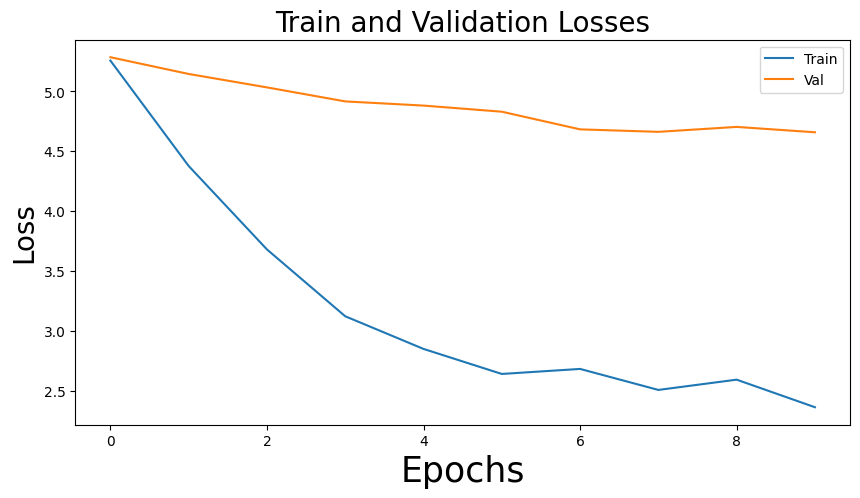

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

#### Inference

In [ ]:
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer

# Load data
train_texts, train_queries, train_answers = load_squad_data(path)

# Load a pre-trained model and tokenizer
model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ensure the model is set in evaluation mode
model.eval()

# Initialize the QA pipeline with the trained model and tokenizer
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# Use a set to track already processed questions
processed_questions = set()

# Perform inference and print out the question, prediction, and actual answer
for i in range(len(train_texts)):
    question = train_queries[i]
    context = train_texts[i]
    ground_truth = train_answers[i]['text']

    # Check if the question has already been processed
    if question in processed_questions:
        continue  # Skip this iteration if the question has been processed
    processed_questions.add(question)  # Add the new question to the set

    # Use the pipeline to make a prediction
    prediction = qa_pipeline({'question': question, 'context': context})

    print(f"Question: {question}")
    print(f"Context: {context}")
    print(f"Predicted Answer: {prediction['answer']}")
    print(f"Ground Truth Answer: {ground_truth}")
    print("\n-----\n")

    if i >= 15:
        break

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: In what country is Normandy located?
Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Predicted Answer: France
Ground Truth Answer: France

-----

Question: When were the Normans in Normandy?
Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who